In [86]:
from importer_snippets import load_experiment
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('JGW')

# Impedance fitting package: https://impedancepy.readthedocs.io/en/latest/index.html
from impedance.models.circuits import CustomCircuit
from impedance.preprocessing import ignoreBelowX
from impedance.visualization import plot_nyquist

In [87]:
EIS_trial = load_experiment()

In [96]:
Zseries = EIS_trial.data['Zre'] + 1j*EIS_trial.data['Zim']
f, Z = EIS_trial.data['f'].to_numpy(), Zseries.to_numpy()
n = 0
for i in Z:
    if np.real(i) < 0 or -np.imag(i) < 0:
        n += 1
print(str(n)+' improperly signed impedances have been excluded')
f, Z = ignoreBelowX(f, Z)

9 improperly signed impedances have been excluded


In [97]:
circuit = 'R0-p(R1,C1)-p(R2-Wo1,C2)'
initial_guess = [.01, .01, 100, .01, .05, 100, 1]
circuit = CustomCircuit(circuit, initial_guess=initial_guess)
circuit.fit(f, Z)
fit = circuit.predict(f)

C:\Users\jgage\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:148: RuntimeWarning: overflow encountered in tanh
  Z = Z0/(np.sqrt(1j*omega*tau)*np.tanh(np.sqrt(1j*omega*tau)))


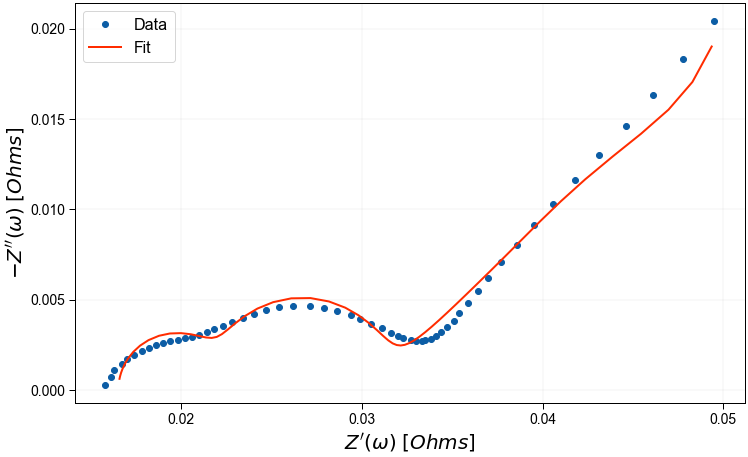

In [98]:
fig, ax = plt.subplots()
plot_nyquist(ax, Z, fmt='o')
plot_nyquist(ax, fit, fmt='-')

plt.legend(['Data', 'Fit'])
plt.show()

In [73]:
EIS = load_experiment()

In [99]:
Zseries = EIS.data['Zre'] + 1j*EIS.data['Zim']
f, Z = EIS.data['f'].to_numpy(), Zseries.to_numpy()
n = 0
for i in Z:
    if np.real(i) < 0 or -np.imag(i) < 0:
        n += 1
print(str(n)+' improperly signed impedances have been excluded')
f, Z = ignoreBelowX(f, Z)

0 improperly signed impedances have been excluded


In [100]:
circuit = 'R1-p(R2-W1,C1)'
initial_guess = [530, 450, 100, 10.0e-6]
circuit = CustomCircuit(circuit, initial_guess=initial_guess)
circuit.fit(f, Z)
fit = circuit.predict(np.linspace(f[0], f[-1], 10000))
# print(circuit)

In [80]:
def save_Nyq_fig(fig, analyte, electrode, solvent, notebook):
    ans = input('Save the figure?')
    if ans in ['y', 'yes', 'Yes', 'yeye', 'yeah', 'why, certainly', True]:
        fig.savefig("C:\\Users\\jgage\\Documents\GitHub\\CHEM274\\data\\figs\\Nyq_"+
            analyte + electrode + solvent + notebook+'.jpg')
        print('Saved')
    else:
        print('Not saved')

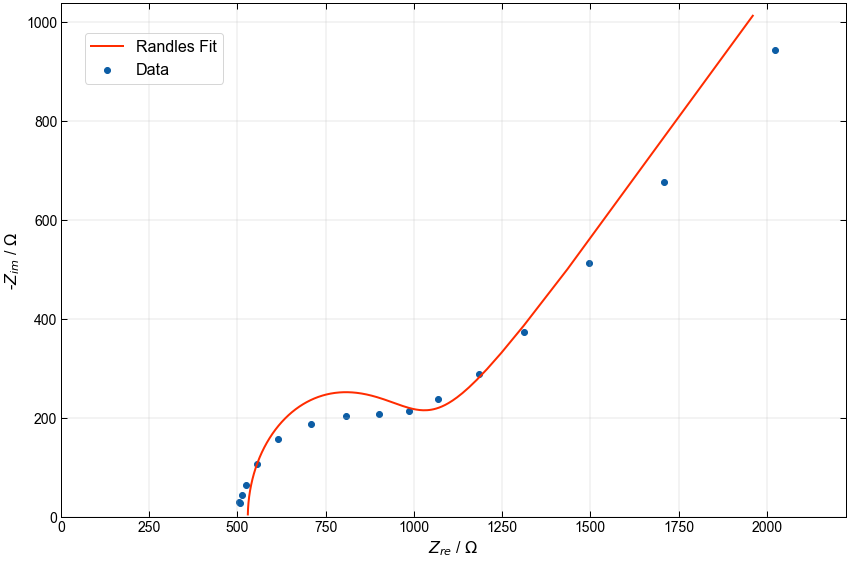

Save the figure? y


Saved


In [103]:
# Nyquist
fig = plt.figure()
ax = fig.add_subplot()

# ax.set_title('Nyquist Plot')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.scatter(EIS2.data['Zre'], -EIS2.data['Zim'], label = 'Data')
ax.set_xlabel('$Z_{re}$ / $\Omega$')
ax.set_ylabel('-$Z_{im}$ / $\Omega$')
ax.set_xlim ([0,1.1*max(EIS.data['Zre'])])
ax.set_ylim ([0,1.1*max(-EIS.data['Zim'])])
ax.plot(np.real(fit), -np.imag(fit), label='Randles Fit', color='C1')
# circuit.plot(ax=ax)

fig.tight_layout()
fig.legend(loc=(.1, .85))

analyte = 'Feacac_'
electrode = 'GC_'
solvent = 'MeCN_'
notebook = '_P-03-04'

plt.show()
save_Nyq_fig(fig, analyte, electrode, solvent, notebook)